In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS

sns.set(style="whitegrid")
sns.set_palette("Paired")

### 1. MNIST 자료를 이용하여 훈련세트 50000 개 검증 세트 10000 개 테스트 세트 10000 개를 뽑은 후 랜덤포레스트 SV M 분류기 등 다양한 분류기를 훈련시킨후 검증세트에서 개개의 분류기 보다 더 높은 성능을 내도록 분류기들을 간접 또 는 직접 투표 방법 을 사용해 앙상블 로 연결해보시요 앙상블 을 얻고 난 후에는 테스트 세트로 확인하여 개개의 분류기와 비교하여 얼마나 성능이 향상되었는지를 파악해보시요

In [2]:
mnist = fetch_openml('mnist_784', version=1) 
#mnist.target = mnist.target.astype(np.uint8)

train, validation, test set 형성을 위해 data와 target(변수명 class)을 하나의 데이터로 만들고,        
index를 random하게 지정하여 train/validation/test로 나눔.

In [3]:
data = pd.concat([mnist['data'], pd.DataFrame(mnist['target'])], axis=1)

idx = list(data.index)
random.shuffle(idx)

train_x = data.iloc[idx[:50000], :-1]
train_y = data.iloc[idx[:50000], -1]
valid_x = data.iloc[idx[50000:60000], :-1]
valid_y = data.iloc[idx[50000:60000], -1]
test_x = data.iloc[idx[60000:], :-1]
test_y = data.iloc[idx[60000:], -1]

In [28]:
train_x.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
29841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
train_y.head()

29841    9
11088    7
25292    4
45032    1
59056    7
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

분류기 생성 - hard와 soft 방식을 이용해서 voting classifier를 형성하고 둘 중 정확도가 더 높은 voting classifier를 최종적으로 test set 예측에 사용한다.

In [4]:
rf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=16,
                           random_state=777)
dt = DecisionTreeClassifier(random_state=777)
svm = SVC(gamma="scale", random_state=777) 
voting_h = VotingClassifier(
estimators = [('rf', rf), ('dt', dt), ('svm', svm)], voting='hard')

validation set을 이용하여 정확도 확인

In [5]:
for model in (rf, dt, svm, voting_h) :
    model.fit(train_x, train_y)
    pred_y = model.predict(valid_x)
    print(model.__class__.__name__, accuracy_score(valid_y, pred_y))

RandomForestClassifier 0.8114
DecisionTreeClassifier 0.8642
SVC 0.9795
VotingClassifier 0.936


In [8]:
svm_p = SVC(gamma="scale", random_state=777, probability=True) #probability 재설정
voting_s = VotingClassifier(
estimators = [('rf', rf), ('dt', dt), ('svm', svm_p)], voting='soft')

voting_s.fit(train_x, train_y)
pred_y_votings = voting_s.predict(valid_x)
accuracy_score(valid_y, pred_y_votings)

0.9333

두 voting classifier 중 hard voting classifier가 더 높은 정확도를 보였고, random forest와 decision tree 하나로 평가한 정확도보다 voting classifier의 정확도가 높은 것을 확인하였다.      
개개의 분류기 및 hard voting classifier로 test data set을 예측하고 정확도를 확인해본다.

In [9]:
for model in (rf, dt, svm, voting_h) :
    pred_test_y = model.predict(test_x)
    print(model.__class__.__name__, accuracy_score(test_y, pred_test_y))

RandomForestClassifier 0.8114
DecisionTreeClassifier 0.8684
SVC 0.98
VotingClassifier 0.9335


test data 예측 결과, random forest와 decision tree를 각각 사용한 것보다 두 모델과 svm 모델을 합한 voting classifier를 사용했을 때 정확도가 높아짐을 알 수 있다. voting classifier는 test data에 대해 93.35%의 정확도를 보였다.

test data set을 예측한 결과 93%의 정확도를 보였다.

### 2. MNIST 자료를 tSNE, PCA , LLE, MDS 를 적용하여 2차원 으로 차원을 축소시킨 후 10개의 class를 각각 다른색 으로 나타낸 산점도 를 그려보시요

In [10]:
tsne = TSNE(n_components=2, random_state=777)  # tSNE
pca = PCA(n_components=2, random_state=777)    # pca
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=777) #lle
mds = MDS(n_components=2, random_state=777)    # mds

In [11]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

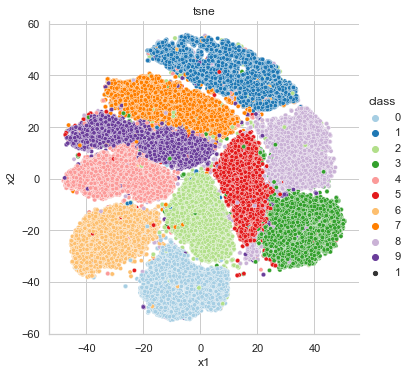

In [31]:
# tSNE
df_tsne=tsne.fit_transform(X)

df_tsne = pd.concat([pd.DataFrame(df_tsne), pd.DataFrame(y)], axis=1).rename(columns={0:'x1', 1:'x2'})
sns.relplot(x='x1', y='x2', hue='class', data=df_tsne ,size=1)
plt.title("tsne");

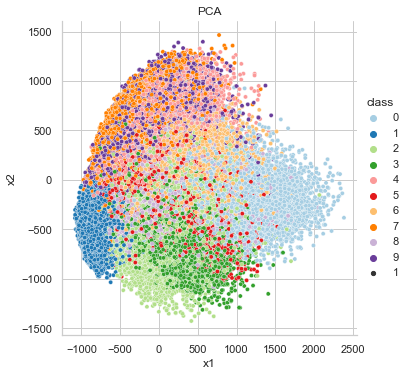

In [27]:
# PCA
pca.fit(X)
df_pca = pca.transform(X)

df_pca = pd.concat([pd.DataFrame(df_pca), pd.DataFrame(y)], axis=1).rename(columns={0:'x1', 1:'x2'})
sns.relplot(x='x1', y='x2', hue='class', data=df_pca ,size=1)
plt.title("PCA");

In [ ]:
# lle
df_lle=lle.fit_transform(X)

df_lle = pd.concat([pd.DataFrame(df_lle), pd.DataFrame(y)], axis=1).rename(columns={0:'x1', 1:'x2'})
sns.relplot(x='x1', y='x2', hue='class', data=df_lle ,size=1)
plt.title("lle");

In [ ]:
# mds
df_mds=mds.fit_transform(X)

df_mds = pd.concat([pd.DataFrame(df_mds), pd.DataFrame(y)], axis=1).rename(columns={0:'x1', 1:'x2'})
sns.relplot(x='x1', y='x2', hue='class', data=df_mds ,size=1)
plt.title("mds");